# Pruning

このチャプターでは、modelのpruningを行っていきます。

In [1]:
%pip install -q tensorflow-model-optimization

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tempfile
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import os
import zipfile

### データセットの準備
評価で使用するため、再度Fashion-MNISTデータセットをロードして、
前処理も行なっておきます。

In [3]:
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = fashion_mnist.load_data()

## shapeを(batch_size, rows, cols, channels)にexpandする
X_train = np.expand_dims(X_train_orig, -1)
X_test = np.expand_dims(X_test_orig, -1)

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

## グレースケールの 0-255 の値を 正規化して 0-1 の浮動小数にする
X_train = X_train / 255.0
X_test = X_test / 255.0

## one hot vectorにする
y_train = tf.keras.utils.to_categorical(y_train_orig, 10)
y_test = tf.keras.utils.to_categorical(y_test_orig, 10)

print("one hot label shape", y_train.shape)

X_train shape (60000, 28, 28, 1)
X_test shape (10000, 28, 28, 1)
one hot label shape (60000, 10)


### モデルのロード
01で保存したFashion-MNISTモデルをロードします

In [4]:
USER    = "rio" # 自分の名前
BUCKET  = "mixi-ml-handson-2022"
VERSION = "001"

base_model = tf.keras.models.load_model("gs://{}/{}/{}".format(BUCKET, USER, VERSION))

# ベースモデルを一時保存しておく
_, base_model_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(base_model, base_model_file, include_optimizer=False)

2022-04-24 16:49:55.499177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 16:49:55.510001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 16:49:55.510615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 16:49:55.512135: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### ベースモデルの精度確認
再度、ベースモデルの評価を確認してみます。

In [5]:
base_model.evaluate(X_test, y_test, batch_size=32)

2022-04-24 16:50:08.416941: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


313/313 [==============================] - 3s 3ms/step - loss: 0.2317 - categorical_accuracy: 0.9279


[0.23173607885837555, 0.9279000163078308]

### 重みの確認

pruningとは、重みが小さいエッジを取り去って、パラメータを削減する手法になります。  
パラメータが少なくなれば、その分モデルのサイズは小さくなり、高速化されます。  
しかし、今回のモデルの重みに削減する余地はあるでしょうか。

実際に重みの値を確認してみましょう。

まず、再度モデルの構成を確認します。

In [6]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                        

この中のうち、`conv2d`と`dense`が層を構成しています。  
これらの層の重みからヒストグラムを作成してみましょう。

In [7]:
import matplotlib.pyplot as plt

def draw_weights_histgram(model, layers_index, bins=1000):
    weight_list = model.layers[layers_index].weights[0].numpy().flatten()
    plt.hist(weight_list, bins=bins)


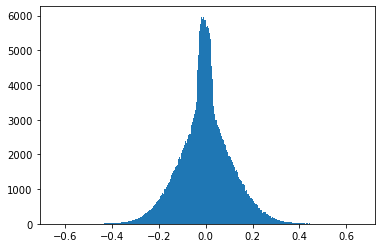

In [8]:
# conv2dまたはdense層のindexを入れて、それぞれの重みをplotしてみましょう
draw_weights_histgram(base_model, 6)

だいたいどの層をplotしてみても、0.0付近に値が集中していたのではないでしょうか。  
0.0付近のweightは、消去しても精度に大きな影響を与えないはずなので、このモデルにはpruningする余地が十分あるといえそうです。

### pruningモデルを定義
公式の[Pruning in Keras example](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras)を参考にpruningモデルを定義します。

In [9]:
import tensorflow_model_optimization as tfmot

def compute_necessary_steps(batch_size, epochs):
    return np.ceil(X_train.shape[0] / batch_size).astype(np.int32) * epochs

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
end_step = compute_necessary_steps(batch_size=32, epochs=5)

# 最初に10%をpruning、最終的には70%をpruningする様にスケジューリング
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.10,
                                                               final_sparsity=0.70,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(base_model, **pruning_params)

/opt/conda/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/opt/conda/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/opt/conda/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


In [10]:
model_for_pruning.compile(
    optimizer='adam',
    loss="categorical_crossentropy", 
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

### 学習
pruningモデルが定義できたので、再学習させます。

In [11]:
%rm -rf ./pruning_logs

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir='pruning_logs'),
]
model_for_pruning.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.1, callbacks=callbacks)

Epoch 1/5
1688/1688 [==============================] - 15s 7ms/step - loss: 0.1466 - categorical_accuracy: 0.9461 - val_loss: 0.1975 - val_categorical_accuracy: 0.9317
Epoch 2/5
1688/1688 [==============================] - 11s 7ms/step - loss: 0.1510 - categorical_accuracy: 0.9432 - val_loss: 0.2040 - val_categorical_accuracy: 0.9303
Epoch 3/5
1688/1688 [==============================] - 11s 7ms/step - loss: 0.1548 - categorical_accuracy: 0.9419 - val_loss: 0.2098 - val_categorical_accuracy: 0.9270
Epoch 4/5
1688/1688 [==============================] - 11s 7ms/step - loss: 0.1637 - categorical_accuracy: 0.9406 - val_loss: 0.2229 - val_categorical_accuracy: 0.9270
Epoch 5/5
1688/1688 [==============================] - 12s 7ms/step - loss: 0.1530 - categorical_accuracy: 0.9429 - val_loss: 0.2066 - val_categorical_accuracy: 0.9320


### 評価
学習が終わったら、これまでと同じように評価してみましょう。

In [ ]:
model_for_pruning.evaluate(X_test, y_test, batch_size=32)

313/313 [==============================] - 1s 3ms/step - loss: 0.2277 - categorical_accuracy: 0.9274


[0.227738618850708, 0.9273999929428101]

モデルの精度はベースモデルと比較してどうなっているでしょうか。  
ほとんど変わってなければ、精度に影響を与えずにpruningされていることになります。

### 可視化
01と同じように、学習結果をtensorboardで可視化してみます。

In [13]:
%load_ext tensorboard

In [15]:
%tensorboard --logdir pruning_logs

学習の推移やshcedule通りにpruningされていったかなどを確認してみてください。

### pruningモデルを圧縮
pruningすることが出来たので、モデルの圧縮を行いましょう。

[公式](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras#create_3x_smaller_models_from_pruning)によると、圧縮を確認するには`tfmot.sparsity.keras.strip_pruning`と標準の圧縮アルゴリズムの適用（gzipなど）の両方が必要とのことなので、
その対応をしていきます。

In [16]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

# pruningしたモデルを一時保存
_, pruned_model_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_model_file, include_optimizer=False)



In [17]:
# gzipを適応した後のsizeをkbで返す関数
def get_gzipped_model_size_kb(file):
    # Returns size of gzipped model, in bytes.
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    return int(os.path.getsize(zipped_file) / 1024)

準備ができたので、各モデルにおける圧縮の効果を確認してみましょう。

In [18]:
print("base model size    : {} kb".format(get_gzipped_model_size_kb(base_model_file)))
print("pruned model size : {} kb".format(get_gzipped_model_size_kb(pruned_model_file)))

base model size    : 3199 kb
pruned model size : 1340 kb


モデルが1/3ほどに圧縮されたことが確認できているでしょうか。